# TP3

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en  
Material_TPs/TP3/images a partir del template Material_TPs/TP3/template
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

In [1]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Inciso 1

### Funciones

#### Funcion match

In [2]:
def match(img, template, meth='cv.TM_CCOEFF_NORMED', k_blur=15, sigma_blur=2):

    '''
    Función para matchear un template con una imagen. Se aplican algunas operaciones
    de transformación para optimizar la búsqueda.

    Devuelve el array del resultado del match
    param img: imagen en la cual se va a buscar el template en escala de grises. un solo canal
    param template: template que se usara para bucar en escala de grises. un solo canal
    param meth: método utilizado
    param k_blur: tamaño del kernel del defengoque gaussiano
    param sigma_blur: sigma del desenfoque gaussiano
    '''

    # img_gray   = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # template   = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

    # Chequeo que las dimensiones del template sea menores a las de la image
    if np.any(np.array(template.shape) > np.array(img.shape)):
        raise AssertionError('El template supera al tamaño de la imagen.\nTemplate:{}\nImagen:{}'.format(template.shape,img.shape))

    # Método
    method = eval(meth)

    # aplico Desenfoque a la imagen escalada
    image2match = cv.GaussianBlur(img, ksize=(k_blur,k_blur), sigmaX=sigma_blur, sigmaY=sigma_blur)

    # aplico Canny a la imagen escalada y a template
    image2match = cv.Canny(image2match, threshold1=5, threshold2=200)
    template2match =  cv.Canny(template, threshold1=5, threshold2=200)

    res = cv.matchTemplate(image2match, template2match, method)

    return res, image2match, template2match

#### Funcion match_template_variable

In [3]:
np.linspace(3,1,4)

array([3.        , 2.33333333, 1.66666667, 1.        ])

In [4]:

def match_template_variable(img, template, meth, min_sf, max_sf, n_templates):

    '''
    Itera sobre diferentes configuraciones de parámetros la función match
    devuelve top_left, template_final, min_val_final, max_val_final, k_final, res_final
    '''

    # Generamos diferentes escalas de la imagen
    # Con el criterio que la imagen no se achique más que el template original y tampoco se agrande
    min_scale_admitida = np.max([(template.shape[0]/img.shape[0]), (template.shape[1]/img.shape[1])])
    min_scale_admitida = min(1, min_scale_admitida)
    escalas_img = np.linspace(min_scale_admitida,1,4)

    # kernel sizes and sigmas para el bluring
    k_blurs = [5,15,25]
    sigmas  = [1, 2,3,5]

    # Método
    method = eval(meth)

    results = []
    min_val_final = 1000000
    max_val_final = -1000000

    for j in escalas_img:
        # Aseguro que la imagen se reescale más pequeña que el template original. Permitiendo que sea la original (escala 1)
        if j < min_scale_admitida and j != 1:
            continue
        image_scaled = cv.resize(img, None, fx=j, fy=j)
        # Criterio para que el template no sea mas grande que la imagen a matchear
        max_scale_admitida = np.min([(image_scaled.shape[0]/template.shape[0]), (image_scaled.shape[1]/template.shape[1])])
        escalas_t = np.linspace(min_sf,max_scale_admitida,n_templates)
        for i in escalas_t:
            template_scaled = cv.resize(template, None, fx=i, fy=i)
            # Aseguro que el template a comparar tenga dimensiones menores a las de a imagen
            if np.any(np.array(template_scaled.shape) > np.array(image_scaled.shape)):
                # print('Template:{}\nImagen:{}'.format(template_scaled.shape,img.shape))
                continue

            for k in k_blurs:
                for sigma_blur in sigmas:
                    res, image2match, template2match = match(img=image_scaled, template=template_scaled, meth=meth, k_blur=k, sigma_blur=sigma_blur)
                    results.append(res)
                    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
                    
                    # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
                    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                        if min_val < min_val_final:
                            min_val_final = min_val
                            top_left = min_loc
                            template_final = template_scaled
                            image_final = image_scaled
                            image2match_final = image2match
                            template2match_final = template2match
                            res_final = res
                            k_final = k
                            sigma_final = sigma_blur
                    else:
                        if max_val > max_val_final:
                            max_val_final = max_val
                            top_left = max_loc
                            template_final = template_scaled
                            image_final = image_scaled
                            image2match_final = image2match
                            template2match_final = template2match
                            res_final = res
                            k_final = k
                            sigma_final = sigma_blur
        
    return top_left, template_final, image_final, min_val_final, max_val_final, k_final, sigma_final, image2match_final, template2match_final, res_final



#### Funcion encontrar_logo_coca

In [5]:
def encontrar_logo_coca(imagen, patron='template/pattern.png',
                        meth='cv.TM_CCOEFF_NORMED', min_sf=0.4, max_sf=2, n_templates=16):

    '''
    Función para encontrar el template en diversas imágenes.
    Devuelve la imagen original con un rectángulo alrededor del objeto
    encontrado.

    param img: ubicacion de la imagen en la cual se va a buscar el template
    param patron: ubicación del archivo del template
    param meth: método utilizado
    param k_blur: tamaño del kernel del defengoque gaussiano
    param sigma_blur: sigma del desenfoque gaussiano
    param min_sf: mínimo factor de escala para reescalar el template
    '''

    img = cv.imread(imagen)
    img_rgb    = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray   = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Leo el template
    template   = cv.imread(patron,0)

    (top_left, 
    template_final, 
    image_final, 
    min_val_final,
    max_val_final,
    k_final,
    sigma_final, 
    image2match_final,
    template2match_final,
    res_final)              =    match_template_variable(img_gray, template, meth=meth, min_sf=min_sf, max_sf=max_sf, n_templates=n_templates)

    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    w, h = template_final.shape[::-1]
    bottom_right = (top_left[0] + w, top_left[1] + h)
    # Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
    img_salida = img_rgb.copy()
    # reescalo la imagen de salida para que se acomode a la imagen escalada final
    img_salida = cv.resize(img_salida, image_final.shape[::-1])
    # Dibujo el rectángulo en la imagen de salida
    cv.rectangle(img_salida,top_left, bottom_right, (0, 255, 0), 2)

    print('-'*100)
    print('Valor Obtenido por el método {} = {}'.format(meth, max_val_final))
    print('Tamaño Imagen Orig: {}'.format(img_gray.shape))
    print('Tamaño Template Orig: {}'.format(template.shape))
    print('Tamaño Template Scaled: {}'.format(template_final.shape))
    print('Tamaño Imagen Scaled: {}'.format(image_final.shape))
    print('Kernel Size del blur: {}'.format(k_final))
    print('Sigma del blur: {}'.format(sigma_final))

    # Graficamos el procesamiento y la salida
    #----------------------------------------
    plt.figure(figsize=(16,16))

    # Resultado de coincidencia
    plt.subplot(141),plt.imshow(res_final,cmap = 'gray')
    plt.title('Matching Result')
    # plt.xticks([]), plt.yticks([])

    # Imagen original con recuadros
    plt.subplot(142),plt.imshow(img_salida)
    plt.title('Detected Point')
    # plt.xticks([]), plt.yticks([])

    plt.subplot(143),plt.imshow(template2match_final, cmap='gray')
    plt.title('Template Scaled')
    plt.subplot(144),plt.imshow(image2match_final, cmap='gray')
    plt.title('Matching Image')

    titulo =    'Imagen: {}\nMétodo: {}\nValor: {}'.format(imagen, meth, max_val_final)
    plt.suptitle(titulo)
    plt.show()

    cv.waitKey()
    cv.destroyAllWindows()

### Aplicacion funcion encontrar_logo_coca a diversas imagenes

#### coca_logo_1.png

----------------------------------------------------------------------------------------------------
Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.38363245129585266
Tamaño Imagen Orig: (500, 207)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (74, 169)
Tamaño Imagen Scaled: (500, 207)
Kernel Size del blur: 15
Sigma del blur: 1


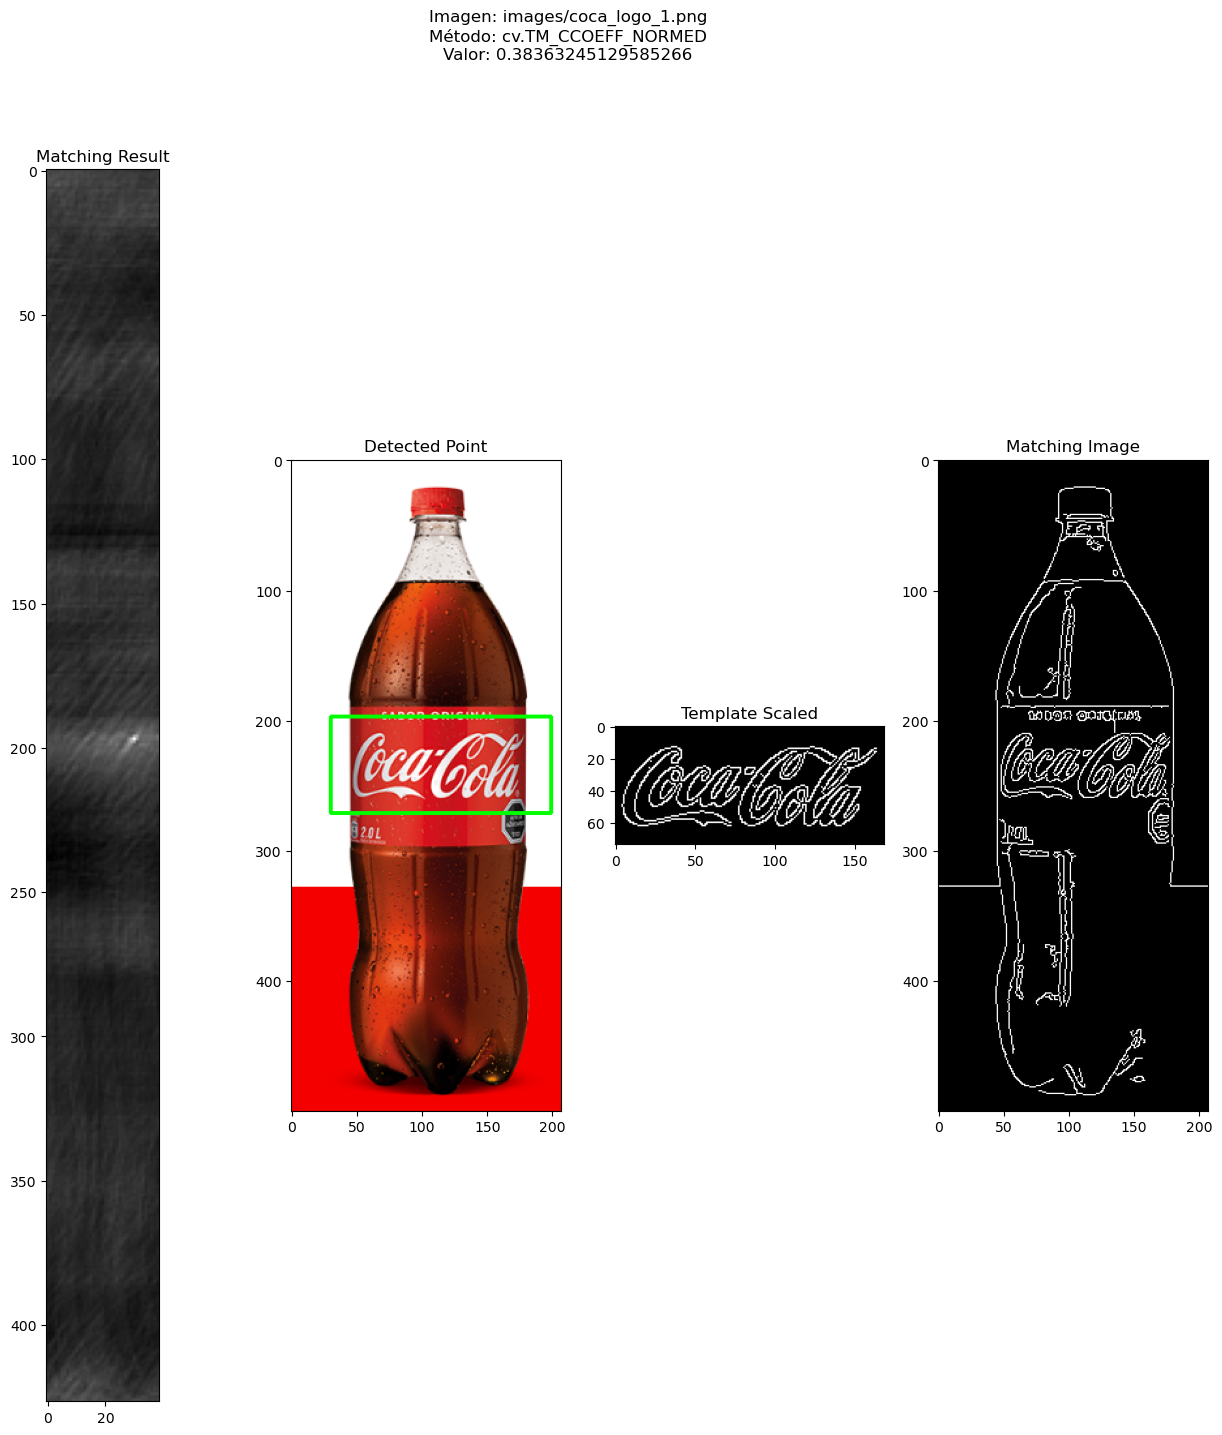

In [6]:
imagen = 'images/coca_logo_1.png'
encontrar_logo_coca(imagen)

#### coca_logo_2.png

----------------------------------------------------------------------------------------------------
Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.12426287680864334
Tamaño Imagen Orig: (363, 233)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (102, 233)
Tamaño Imagen Scaled: (363, 233)
Kernel Size del blur: 15
Sigma del blur: 1


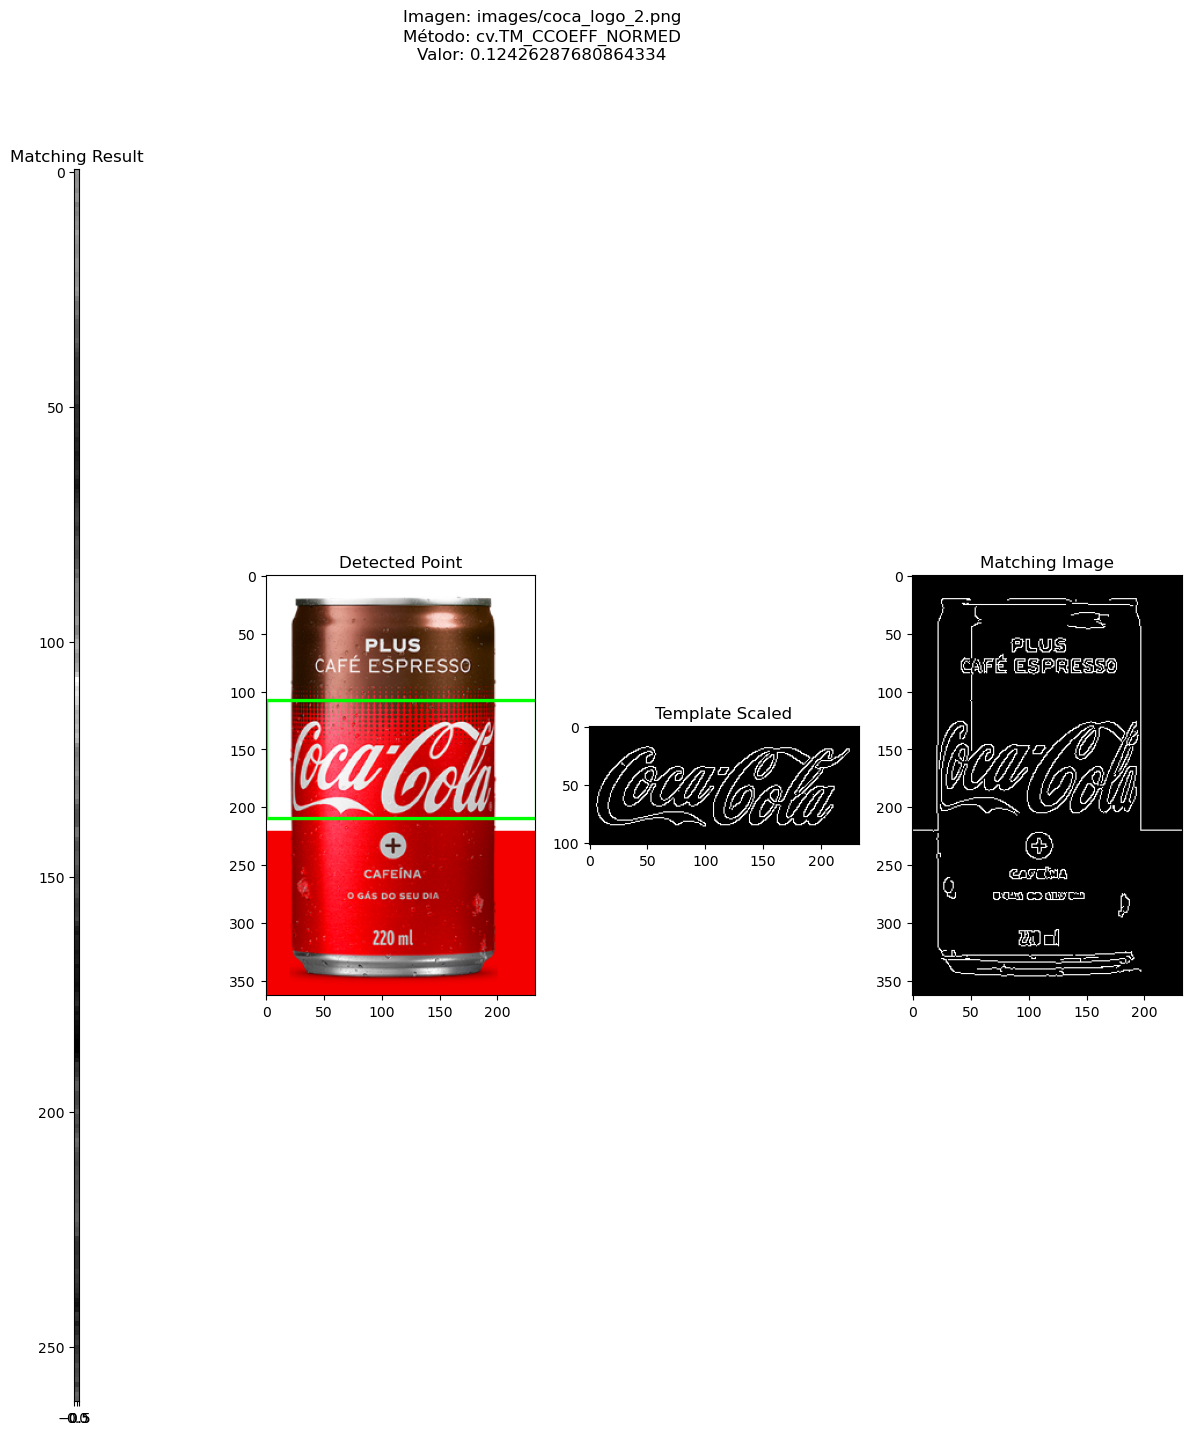

In [7]:
imagen = 'images/coca_logo_2.png'
encontrar_logo_coca(imagen)

#### coca_retro_1.png

----------------------------------------------------------------------------------------------------
Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.1598958671092987
Tamaño Imagen Orig: (493, 715)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (133, 304)
Tamaño Imagen Scaled: (276, 400)
Kernel Size del blur: 15
Sigma del blur: 3


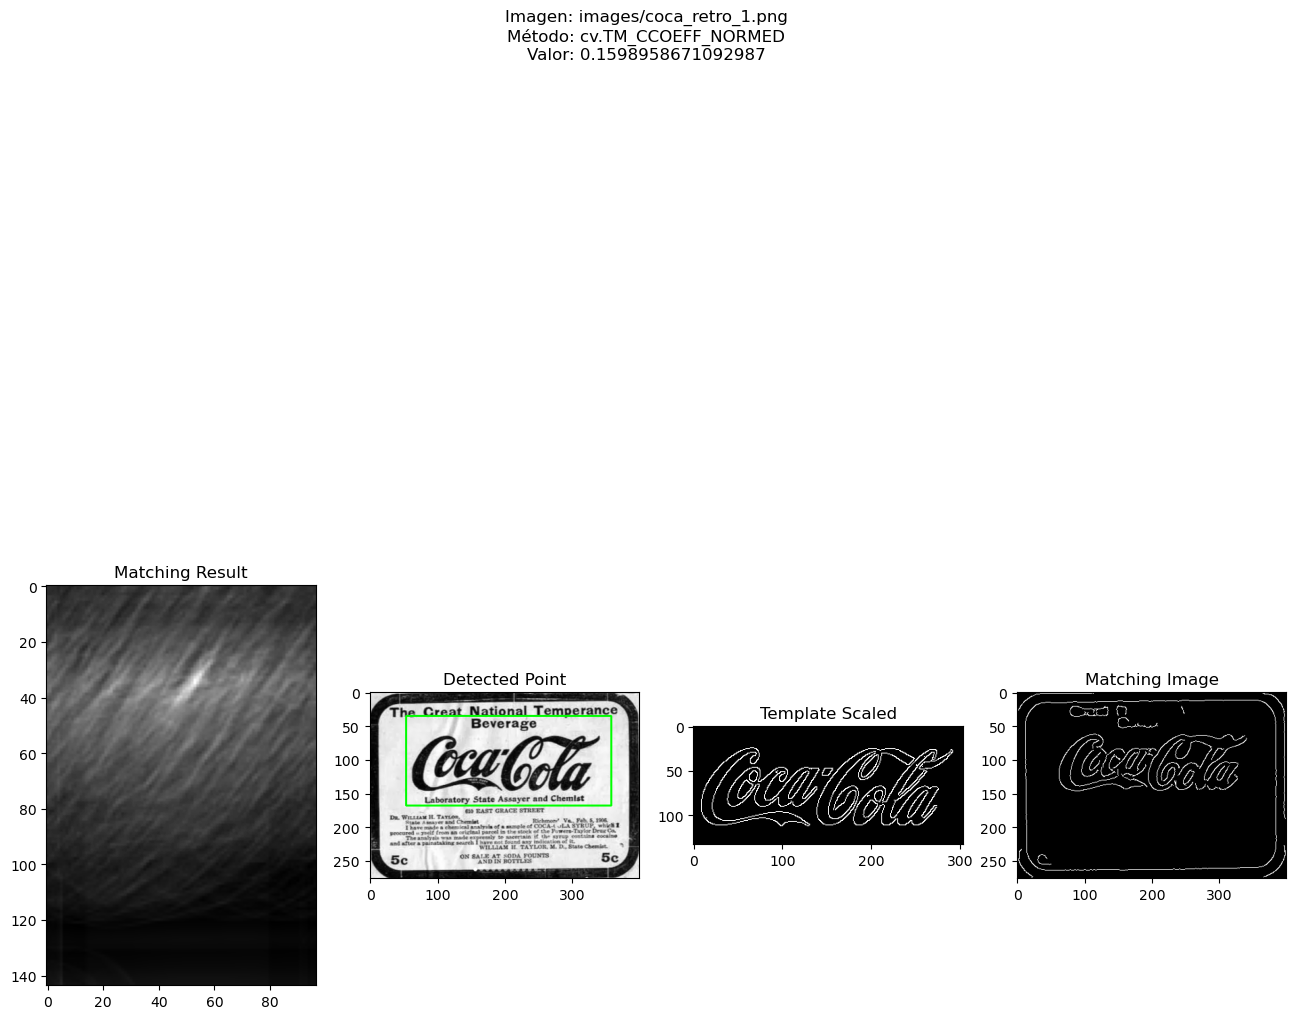

In [8]:
imagen = 'images/coca_retro_1.png'
encontrar_logo_coca(imagen, min_sf=0.4)

#### coca_retro_2

----------------------------------------------------------------------------------------------------
Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.3059152662754059
Tamaño Imagen Orig: (429, 715)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (70, 160)
Tamaño Imagen Scaled: (429, 715)
Kernel Size del blur: 5
Sigma del blur: 1


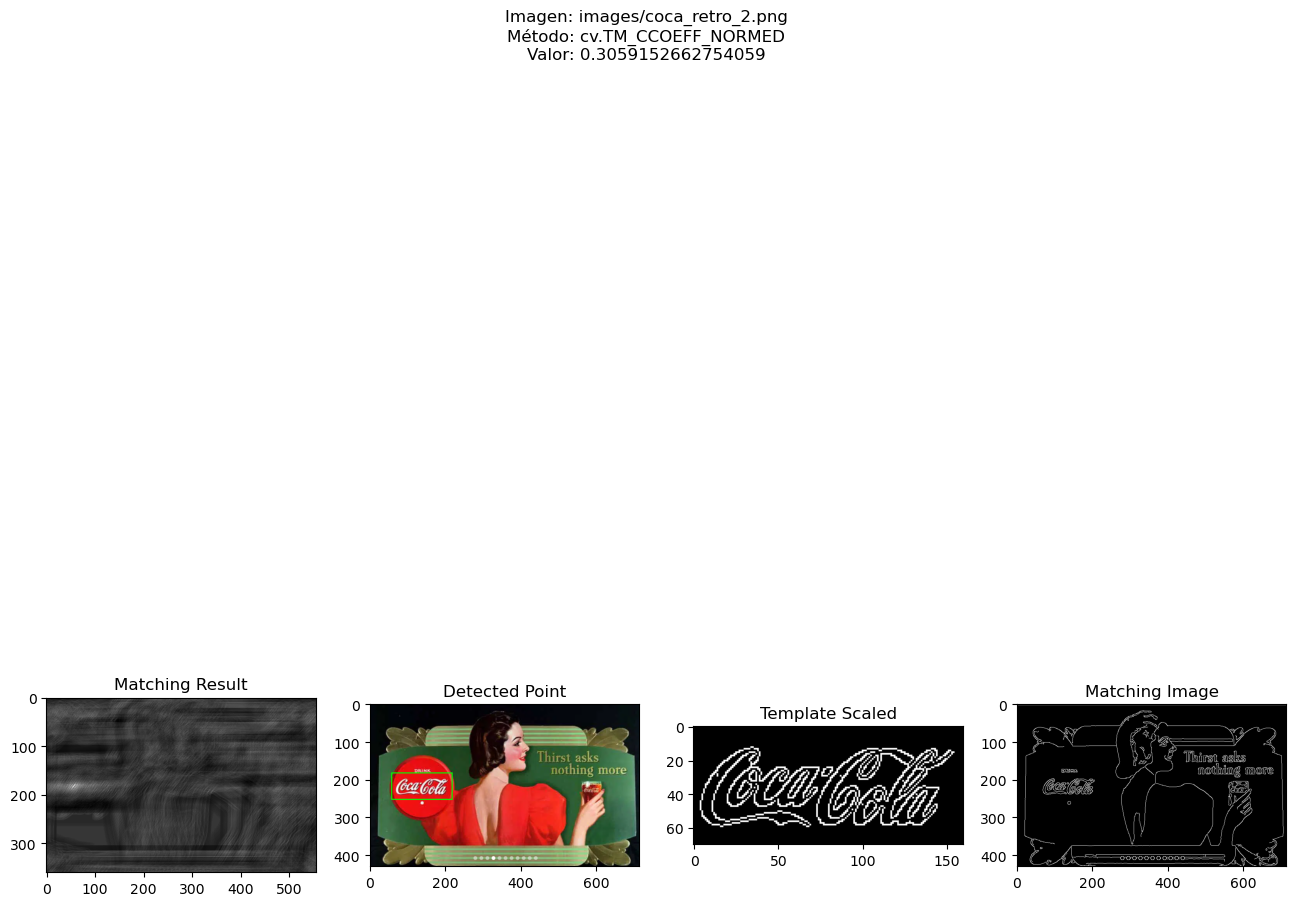

In [9]:
imagen = 'images/coca_retro_2.png'
encontrar_logo_coca(imagen)

#### COCA-COLA-LOGO.jpg

----------------------------------------------------------------------------------------------------
Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.17355233430862427
Tamaño Imagen Orig: (1389, 1389)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (161, 368)
Tamaño Imagen Scaled: (400, 400)
Kernel Size del blur: 15
Sigma del blur: 3


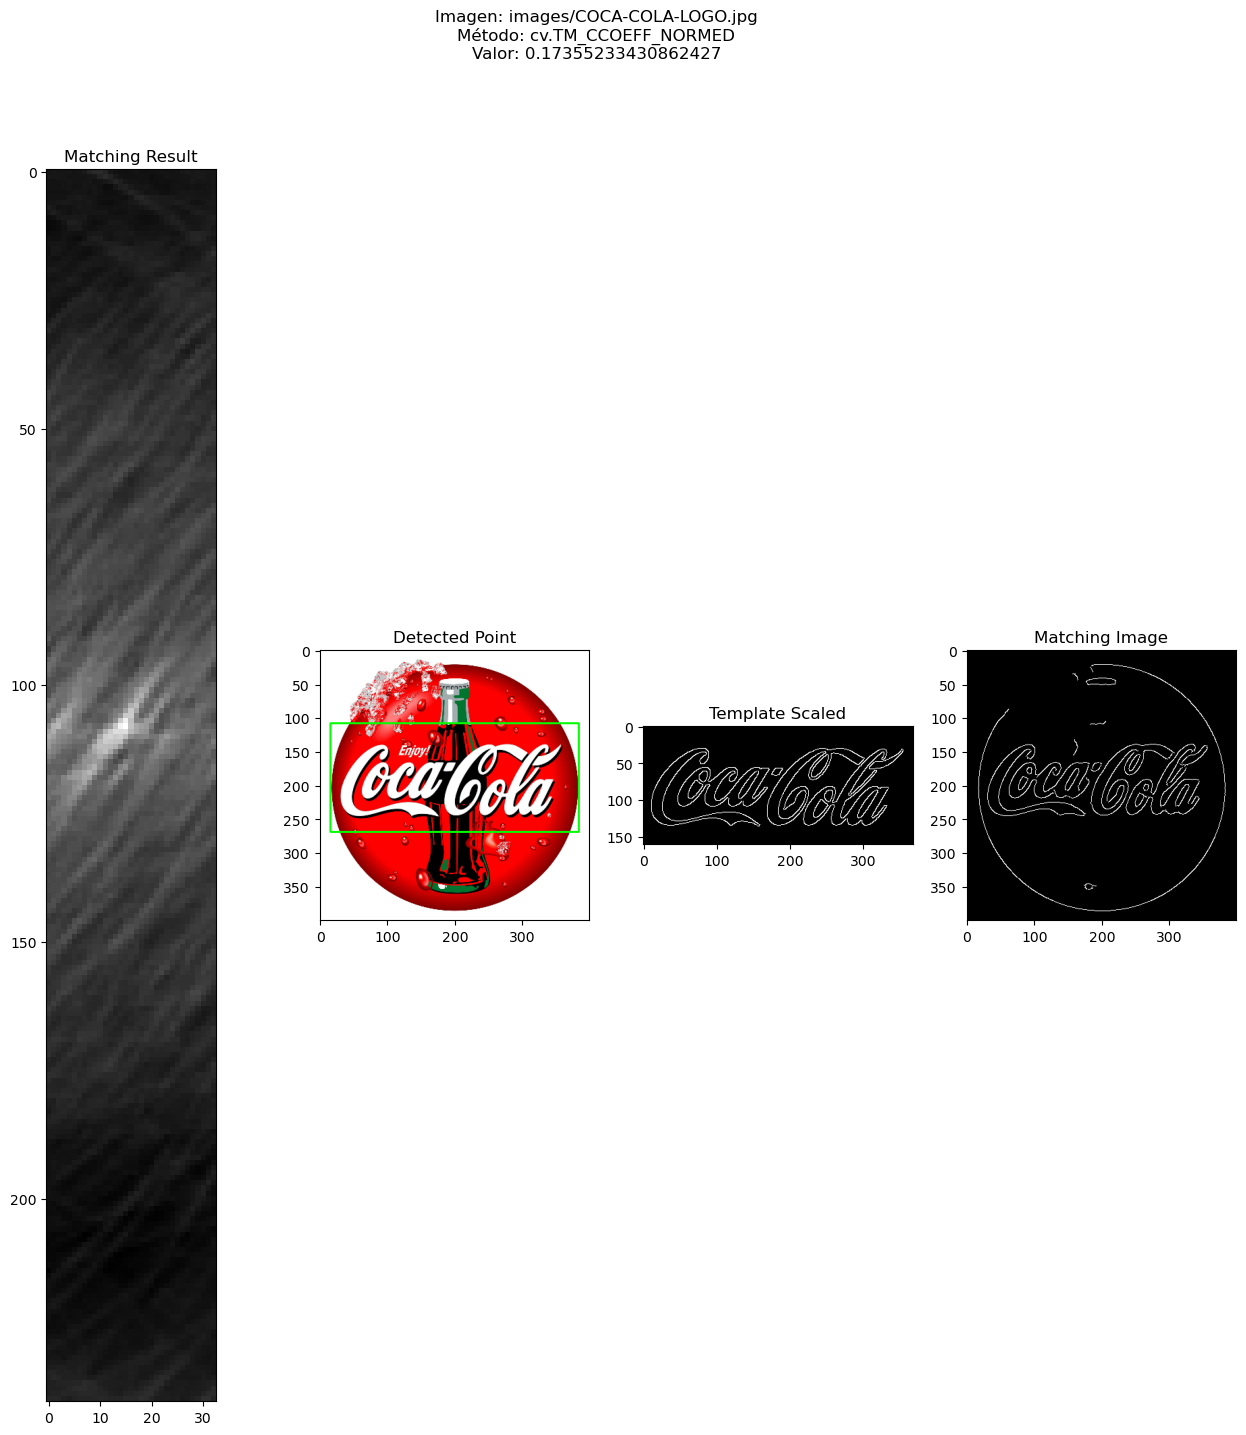

In [10]:
imagen = 'images/COCA-COLA-LOGO.jpg'
encontrar_logo_coca(imagen)

#### logo_1.png

----------------------------------------------------------------------------------------------------
Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.19488392770290375
Tamaño Imagen Orig: (450, 687)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (77, 176)
Tamaño Imagen Scaled: (262, 400)
Kernel Size del blur: 15
Sigma del blur: 1


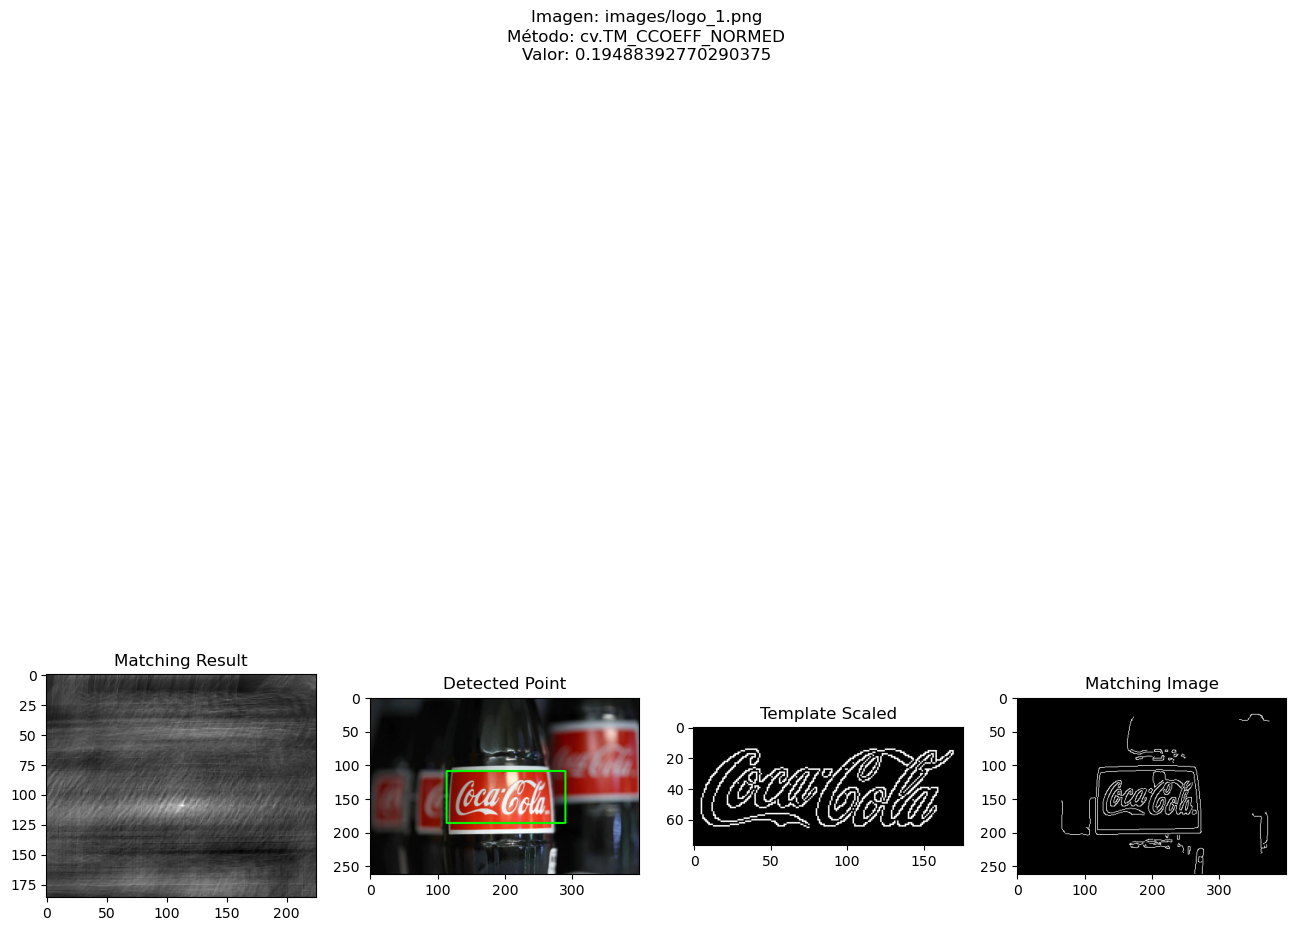

In [11]:
imagen = 'images/logo_1.png'
encontrar_logo_coca(imagen)